In [14]:
import torch
import GNNforImputation.imputation_tripartite_graph as imp_graphs
from argparse import Namespace
import pandas as pd
import numpy as np

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

original_data_file_name = 'data/fodors_zagats-master.csv'
missing_value_file_name = 'data/fodors_zagats_city_10perc.csv'

random_init = True

pickle_file_name = None

graph_method = 'triplet'

# if args.external_feats:
#     node_mapping, ext_features = read_external_features(args.external_feats)
# else:
ext_features = None
node_mapping = None

pos_neg_scale_factor = 1


In [16]:
if graph_method == 'edge':
    predict_edges = True
    graph_dataset = imp_graphs.ImputationTripartiteGraphEdgePrediction(original_data_file_name,
                                                                              missing_value_file_name,
                                                                              random_init,
                                                                              node_mapping, ext_features,
                                                                              pos_neg_scale_factor)
elif graph_method == 'triplet':
    predict_edges = False
    graph_dataset = imp_graphs.ImputationTripartiteGraphTripletPrediction(original_data_file_name,
                                                                                     missing_value_file_name,
                                                                                     random_init,
                                                                                     node_mapping, ext_features,
                                                                                     predict_edges,
                                                                                 pos_neg_scale_factor)

Loading and computing basic stats
Creating graph structure
Graph has 4152 nodes and 20388 edges
Computing graph features
Creating positive and negative pos_triplets for training
Size of training positive and negative pos_triplets  5097 5097
Creating positive and negative pos_triplets for testing
Size of testing positive and negative pos_triplets  87 4211
positive test pos_triplets 87
negative test pos_triplets 4211


In [17]:
train_pos = graph_dataset.train_positive_samples
train_neg = graph_dataset.train_negative_samples

In [18]:
train_neg.shape

torch.Size([5097, 3])

In [19]:
df_pos = pd.DataFrame(data=train_pos.tolist(), columns=['rid', 'cid', 'value'])
df_neg = pd.DataFrame(data=train_neg.tolist(), columns=['rid', 'cid', 'value'])

idx2val = graph_dataset.idx2val
full_dataset = graph_dataset.df_orig

In [20]:
df_pos['value'] = df_pos['value'].apply(lambda x: idx2val[x])
df_neg['value'] = df_neg['value'].apply(lambda x: idx2val[x])

In [21]:
print(df_pos.value_counts('value'))
print(df_neg.value_counts('value'))

value
new_york           228
american           152
san_francisco      127
atlanta            107
italian             98
                  ... 
320_hayes_st         1
321                  1
321_w_46th_st        1
322                  1
zuni_cafe_grill      1
Length: 3281, dtype: int64
value
new_york           224
american           152
san_francisco      132
atlanta            104
italian             98
                  ... 
320_hayes_st         1
321                  1
321_w_46th_st        1
322                  1
zuni_cafe_grill      1
Length: 3282, dtype: int64


In [22]:
pos_counts = df_pos.value_counts('value')
neg_counts = df_neg.value_counts('value').drop('nan')

In [23]:
missing_values = [x for x in pos_counts.index if x not in neg_counts.index]
ms = pd.Series([0]*len(missing_values), index=missing_values)
neg_counts = neg_counts.append(ms)

<ipython-input-23-30cb00f76641>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ms = pd.Series([0]*len(missing_values), index=missing_values)


Text(0, 0.5, 'neg')

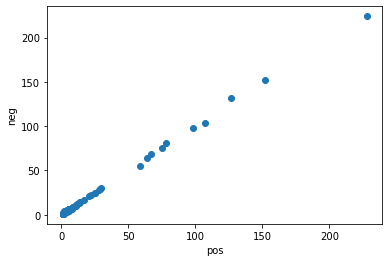

In [24]:
import matplotlib.pyplot as plt

plt.scatter(pos_counts.sort_index(), neg_counts.sort_index())
plt.xlabel('pos')
plt.ylabel('neg')

In [25]:
freq_pos = pos_counts[pos_counts>100]
freq_pos

value
new_york         228
american         152
san_francisco    127
atlanta          107
dtype: int64

In [13]:
neg_counts.loc[freq_pos.index]


value
new_york         218
american         152
san_francisco    129
atlanta          110
dtype: int64

In [26]:
df_adult = pd.read_csv('data/adult_nonulls.csv')
df_adult.sample(frac=0.1).to_csv('data/adult_nonulls_sample10.csv', index=False)